# Offshore CIOPS Quantitative Runs

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import datetime as dt
import math

### general variables:

In [2]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [4]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
init = [1,259, 274, 640,250] #v
North = [2, 531, 585, 320, 220] #h
Sshelf = [5, 634, 644, 200, 180] #h
Sslope = [4, 579, 633, 200, 500] #h
offshore = [3, 199, 300, 560, 500] # v

In [5]:
salfileS17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20170401_20170930.nc')
salfileW16 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20161001_20170331.nc')
salfileW17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20171001_20180331.nc')

### general functions:

In [6]:
# sig figs
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [7]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(len(t_depths)-1):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

# lets see if we can unfold the accordion 

In [11]:
data = Sdata

In [104]:
time = data.init_t[-1]
xloc = data.final_lon[data.final_section == 3]
depths = depthf(data.final_z[data.final_section == 3])[0]
yloc = data.final_lat[data.final_section == 3]
trans = data.final_transp[data.final_section==3]/time
salt = data.final_salt[data.final_section == 3]

In [15]:
# [section, jgridS, jgridN, figrid, maxdepth]
offshore

[3, 199, 300, 560, 500]

In [22]:
jgrid = 555-1
latN = 319
latS = 199

t_lat = mymesh.gphit[0,:,jgrid]
m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, jgrid].sum()))

In [32]:
igrid = 259-1
lonE = 578
lonW = 531

t_lons = mymesh.glamt[0, igrid]
m2lon = ((t_lons[lonW]-t_lons[lonE])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))

In [24]:
t_depths = mymesh.gdept_1d[0,:]

In [35]:
dist = xloc/m2lon + yloc/m2lat

In [40]:
distN = (dist - np.min(dist))

In [44]:
numbins = (latN-latS) + (lonE-lonW)

In [47]:
bins = [np.linspace(0,np.max(distN),numbins), t_depths]

In [61]:
maxdepth=500

In [56]:
H1, xedges, yedges = np.histogram2d(distN, depths, bins=bins, weights= trans, density= True)
t_max = (0.01/np.sum(trans)).values
tick = np.round(((t_max*sum(trans)).values),2)
cmap = cm.speed

In [148]:
bins2=[np.linspace(0,np.max(distN)+20000,14),t_depths]

In [149]:
H = binned_statistic_2d(distN, depths, salt, statistic=np.mean, bins=bins2)
_, xedges2, yedges2 = np.histogram2d(distN, depths, bins = bins2)
h = H.statistic.T

<a list of 6 text.Text objects>

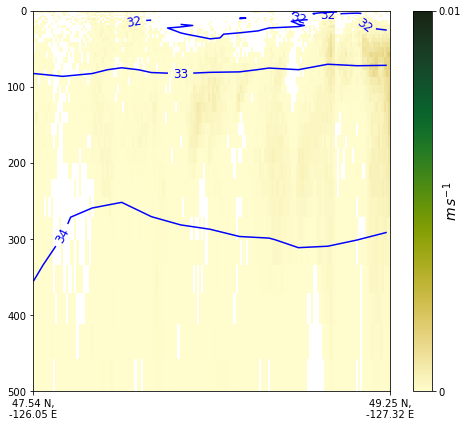

In [152]:
H1 = np.where(H1>0, H1, H1*np.nan)
X, Y = np.meshgrid(xedges, yedges)
X2, Y2 = np.meshgrid(xedges2, yedges2)

cmap.set_bad('white')

fig, ax = plt.subplots(1,1,figsize=(8,7))
im = ax.pcolormesh(X, Y, H1.T, vmax = t_max, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, t_max])
cb1.set_ticklabels([0, tick]) 
cb1.set_label('$m \, s^{-1}$', labelpad=-20, fontsize=14)
ax.invert_yaxis()
ax.set_ylim((maxdepth, 0))
ax.set_xlim((0,np.max(distN)))

ax.set_xticks([np.min(distN),np.max(distN)])
ticklabels = [str(np.round(t_lat[latS],2).values) +' N,\n'+ str(np.round(t_lons[lonE],2).values) + ' E', str(np.round(t_lat[latN],2).values) +' N,\n'+ str(np.round(t_lons[lonW],2).values) + ' E']
ax.set_xticklabels(ticklabels)



CS = ax.contour(X2[:-1,:-1],Y2[:-1,:-1], h, [32,33,34], colors='b', zorder = 2)
ax.clabel(CS, inline=1, fontsize=12)

In [65]:
np.max(distN/1000)

<xarray.DataArray ()>
array(277.00453688)

In [75]:
str(np.round(t_lat[latS],2).values) +',\n'+ str(np.round(t_lons[lonE],2).values)

'47.54,\n-126.05'

In [72]:
str(np.round(t_lons[lonE],2))

"<xarray.DataArray 'glamt' ()>\narray(-126.05, dtype=float32)"